100%|██████████| 94.3M/94.3M [00:00<00:00, 216MB/s]


Classes: ['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake']


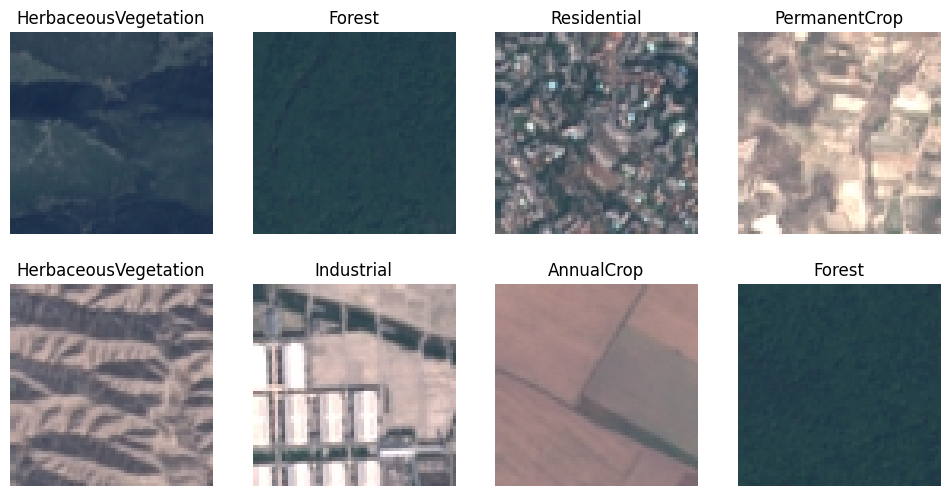

In [1]:
import torch
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

# Transform: resize + normalize
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5],
                         std=[0.5, 0.5, 0.5])
])

dataset = torchvision.datasets.EuroSAT(root="./data", download=True, transform=transform)
print("Classes:", dataset.classes)

def imshow(img, title):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.title(title)
    plt.axis("off")

dataloader = DataLoader(dataset, batch_size=8, shuffle=True)
images, labels = next(iter(dataloader))

plt.figure(figsize=(12,6))
for i in range(8):
    plt.subplot(2,4,i+1)
    imshow(images[i], dataset.classes[labels[i]])
plt.show()


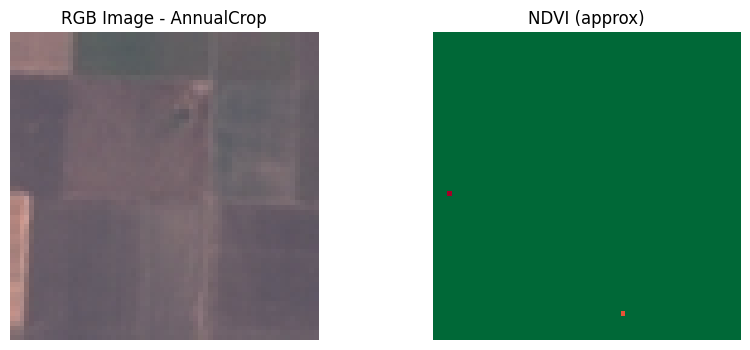

In [2]:

import numpy as np
import matplotlib.pyplot as plt


sample_img, label = dataset[0]
r, g, b = sample_img[0], sample_img[1], sample_img[2]

ndvi = (g - r) / (g + r + 1e-6)

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.imshow(np.transpose(sample_img.numpy(), (1,2,0))*0.5+0.5)
plt.title(f"RGB Image - {dataset.classes[label]}")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(ndvi, cmap="RdYlGn")
plt.title("NDVI (approx)")
plt.axis("off")

plt.show()


In [3]:
import torch.nn as nn
import torch.optim as optim
from torchvision import models

model = models.resnet18(pretrained=True)

num_classes = len(dataset.classes)
model.fc = nn.Linear(model.fc.in_features, num_classes)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

print(model)


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 55.3MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [4]:


from torch.utils.data import DataLoader, random_split

train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

def train_model(model, criterion, optimizer, train_loader, val_loader, epochs=3):
    train_losses, val_losses, val_accs = [], [], []

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for imgs, labels in train_loader:
            imgs, labels = imgs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        # Validation
        model.eval()
        val_loss, correct, total = 0.0, 0, 0
        with torch.no_grad():
            for imgs, labels in val_loader:
                imgs, labels = imgs.to(device), labels.to(device)
                outputs = model(imgs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                _, preds = torch.max(outputs, 1)
                correct += (preds == labels).sum().item()
                total += labels.size(0)

        val_acc = 100 * correct / total
        train_losses.append(running_loss/len(train_loader))
        val_losses.append(val_loss/len(val_loader))
        val_accs.append(val_acc)

        print(f"Epoch [{epoch+1}/{epochs}] "
              f"Train Loss: {running_loss/len(train_loader):.4f} "
              f"Val Loss: {val_loss/len(val_loader):.4f} "
              f"Val Acc: {val_acc:.2f}%")

    return train_losses, val_losses, val_accs

train_losses, val_losses, val_accs = train_model(model, criterion, optimizer, train_loader, val_loader, epochs=3)


Epoch [1/3] Train Loss: 0.3813 Val Loss: 0.2755 Val Acc: 91.00%
Epoch [2/3] Train Loss: 0.2119 Val Loss: 0.2472 Val Acc: 91.41%
Epoch [3/3] Train Loss: 0.1548 Val Loss: 0.2022 Val Acc: 93.24%


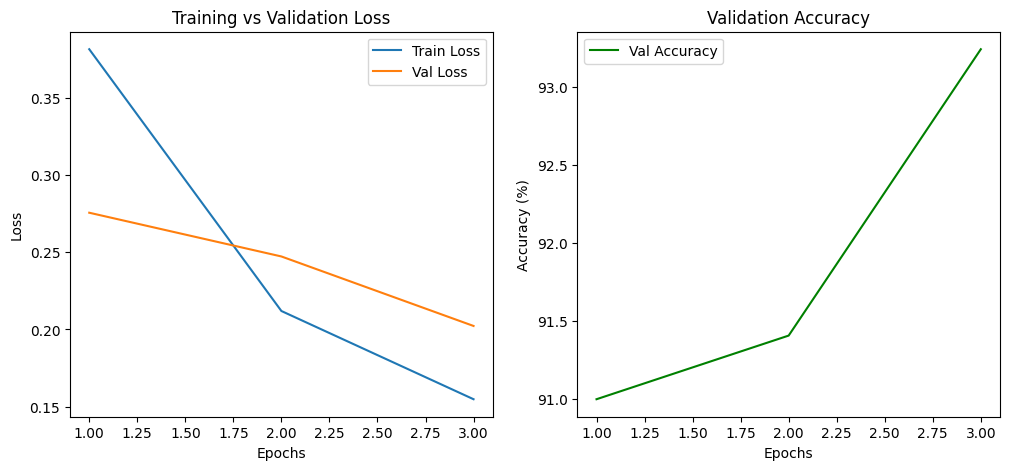

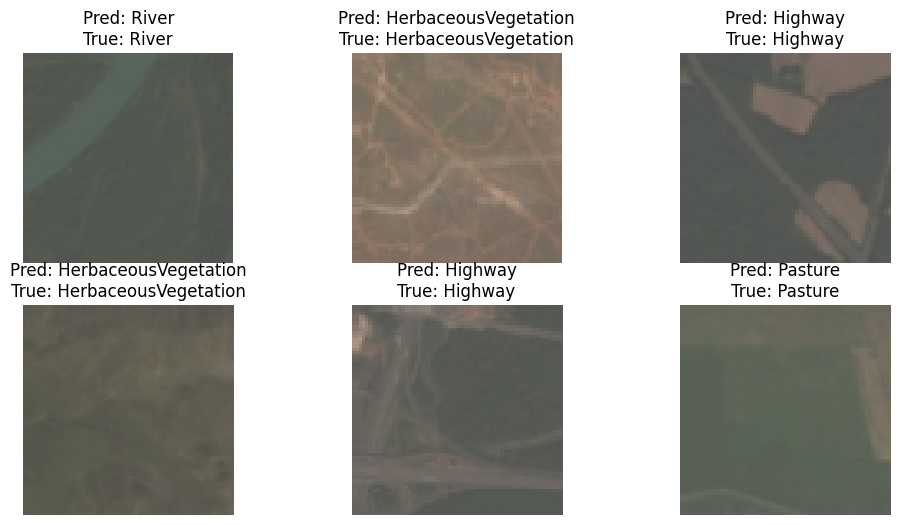

In [5]:
import matplotlib.pyplot as plt
import numpy as np

epochs_range = range(1, len(train_losses)+1)

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(epochs_range, train_losses, label='Train Loss')
plt.plot(epochs_range, val_losses, label='Val Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.subplot(1,2,2)
plt.plot(epochs_range, val_accs, label='Val Accuracy', color='green')
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.title("Validation Accuracy")
plt.legend()

plt.show()
model.eval()
data_iter = iter(val_loader)
images, labels = next(data_iter)
images, labels = images.to(device), labels.to(device)

with torch.no_grad():
    outputs = model(images)
    _, preds = torch.max(outputs, 1)

images = images.cpu().numpy().transpose((0,2,3,1))

# Denormalize
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
images = std * images + mean
images = np.clip(images, 0, 1)

plt.figure(figsize=(12,6))
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.imshow(images[i])
    plt.title(f"Pred: {dataset.classes[preds[i]]}\nTrue: {dataset.classes[labels[i]]}")
    plt.axis('off')
plt.show()
